#Time-warping Invarinat Quantum Recurrent Neural Networks via Quantum-Classical Adaptive Gating -- Tutorial

This is a brief tutorial for different elements of the code for TWI-QRNNs. After a brief introduction to the model, we move on to imporiting libraries,  building the circuit, and setting up the optimization.

##Qunatum Recurrent Neural Network

A Qunatum Recurrent Neural Network (QRNN) [1], [2] is a quantum circuit that can map classical sequences $x_{1:T}$ comprising $T$ samples $x_t$ with $t=1,2,...,T$,  to corresponding classical sequences $z_{1:T}$, comprising samples $z_t$ with $t=1,2,...,T$,  through a parameterized causal mapping operating over time $t$ is defined by a parameterized unitary transformation $U(x, \theta)$ operating on a register of  $n=n^A+n^B$ qubits. The unitary is a function of the real-valued input vector $x$ and of a vector of real-valued model parameters $\theta$. The ansatz, i.e., architecture, assumed in [2] for the unitary $U(x,\theta)$ includes an input encoding layer with single-qubit rotations dependent on input $x$, followed by parameterized processing layers with both single-qubit and two-qubit gates. Note, however, that we allow the dependence of the unitary $U(x,\theta)$ to be arbitrary.

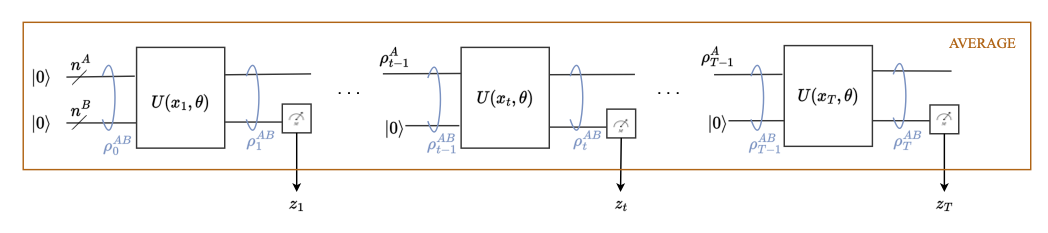

As shown above, the unitary is applied at each time step by re-initializing the subregister of $n^B$ qubits to the ground state $|0\rangle$. After the application of the unitary to all $n$ qubits, the subregister of $n^B$ qbits is measured. Since the subregister of $n^A$ qubits is not measured, it can be used to propagate information from one time step to the next. Therefore, we will refer to the $n^A$-qubit subregister as the *memory subregister*, while the subsystem of $n^B$ qubits is referred to as the *output subregister*.

##Time-warping Invariant Qunatum Recurrent Neural Network

A time-warping operation $c(t)$ is defined as as any monotonically increasing function of time. A simple example are operations of the form $c(t)=a t$ for some range of values $a>0$, which correspond to a stretching ($a<1$) or shrinking ($a>1$) of the time axis [3]. The time-warping invariant counterpart of the QRNN (TWI-QRNN) evaluates the output $z_t$ for time $t$, by generating a number of realizations of  $t-1$ Bernoulli random variables $b_1,...,b_{t-1}$, with each random variable $b_t \sim \text{Bern}(\alpha_t)$ being equal to $1$ with probability $\alpha_t$. The probability should, in theory, be chosen equal to the time-warping derivative
$dc(t)/dt$. For each realization $b_1,...,b_{t-1}$, at time $t'<t$, a unitary $U(x_{t'},\theta)$ is applied to the memory and output subregisters if $b_{t'}=1$ and an identity is applied otherwise, followed by a measurement of the output register. The outputs of the measurement of the output register at time $t$ are then averaged to obtain $z_t$.

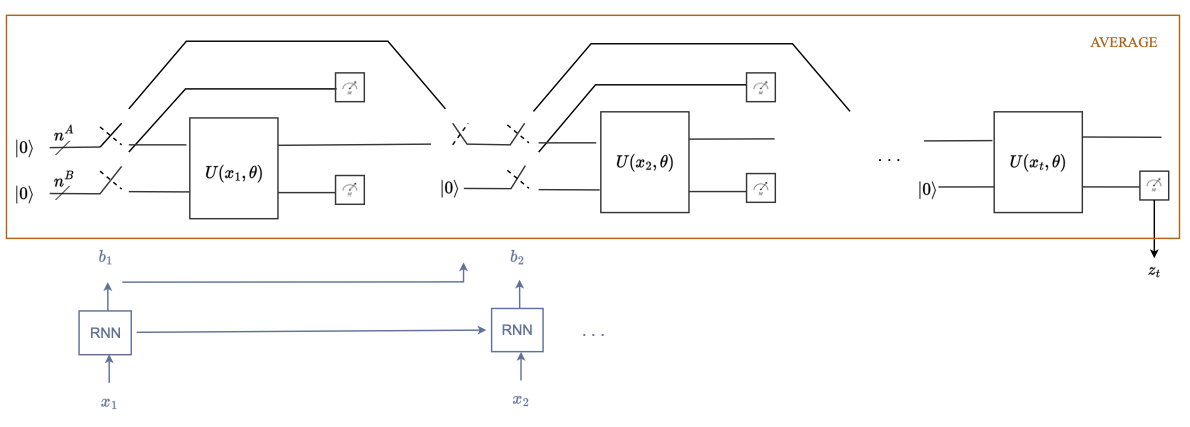





# Gating Mechanism

In practice, the TWI-QRNN practically replaces the unknown derivative in the model $dc(t)/dt$ with a classical recurrent neural network model (RNNs) that infers a suitable time-warping probability $\alpha_t$ from the input data sequence in a causal fashion. Specifically, we write the probability $\alpha_t$ as
$$\alpha_t = \sigma (\phi_t),$$
where $\sigma(a)=(1+\exp(-a))^{-1}$ denotes a logistic sigmoid with *hyperparameter vector* $\phi_t$ being the output of a model defined by the updates
$$\phi_t = W_x x_t + W_h h_t + b,$$
and
$$h_t = \text{tanh} (W^h_x x_t + W^h_h h_{t-1} + b),$$
where $W = \{W_x, W_h, W^h_x, W^h_h\}$ denote learnable parameters.

#Libraries

In [1]:
#!pip install qiskit-terra==0.18.0 qiskit-aer==0.8.2 qiskit-ibmq-provider==0.15.0 qiskit-ignis==0.6.0 qiskit-aqua==0.9.4  # when running the code over again, comment this line, unless the kernel is restarted
!pip install qiskit==0.37.1
!pip install pylatexenc   # when running the code over again, comment this line, unless the kernel is restarted

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.3 MB/s eta 0

In [2]:
import qiskit
qiskit.__version__
from qiskit import transpile, assemble, ClassicalRegister, QuantumRegister
from qiskit.visualization import *
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.opflow import X, Y, Z, I
from qiskit.result import marginal_counts
import math
from math import sqrt, pi
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from collections import namedtuple
import pkg_resources
pkg_resources.require("scipy==1.10.1") #was 1.10.1
from scipy.optimize import minimize

In [4]:
IterLoss = namedtuple("Stats_Loss",["iter_Loss"])

#Data

Here we consider the task of remembering the past sample of a simple classical time sequence $x_t$, namely a, possibly time-warped, discrete-time cosine function. Accordingly, we set the target sequence as $\bar{z}_{t}=x_{t-1}$ for (TWI-)QRNNs. The considered cosine function is given by
$$\text{cos}(t) = \frac{\text{cos}\left(\pi\frac{t}{5}\right)+1}{2}.$$
The ``unwarped'' sequence is shown below.

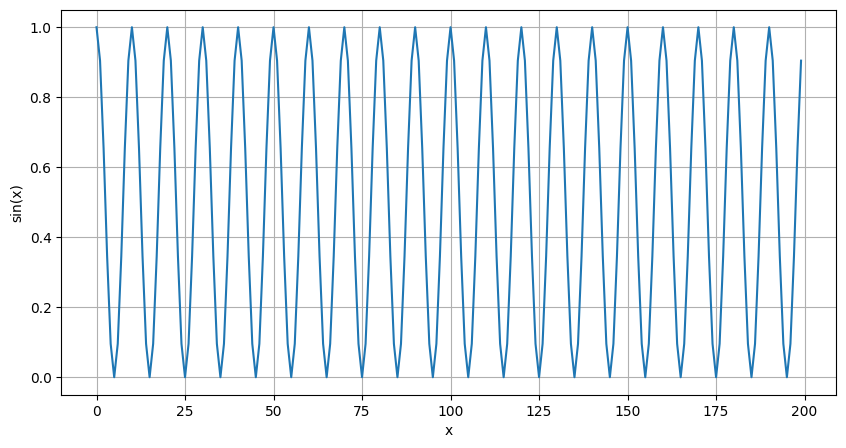

In [5]:
phi_true = 0.05 # true linear time-warping coefficient
repeats = 1/phi_true # number of repetitions to obtain the warpped sequence

phi_sh = 5

num_samples = 200 #total number of samples
num_samples_tr = 50 #number of samples used for training

def get_data(time):

    x = np.zeros([time])
    for t in range(0, time):
        x[t] = (np.cos(np.pi*t/5)+1)/2

    return x



time_unwarped = num_samples
data_samples_unwarped = get_data(time_unwarped)

fig1 = plt.figure(figsize=(10,5))
plt.plot(data_samples_unwarped)
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid()
plt.show(fig1)

We apply linear time-warping to obtain ``warped'' input sequences $x_t$. Given the unwarped sequence $x_t$ obtained by sampling the original cosine signal $\cos(t)$, we repeat each sample for $1/a$ time instants, where  $a$ is such that the ratio $1/a$ is an integer. This setting accounts for a sampler with memory, as a new sample is observed every $1/a$ time steps. The warped signal is shown below.

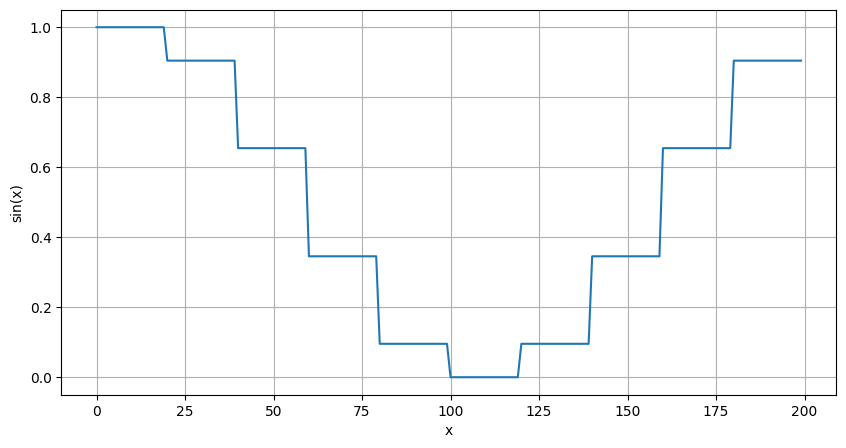

In [6]:
time_warped = np.repeat(time_unwarped, repeats)[0:num_samples]
data_samples_warped = np.repeat(data_samples_unwarped, repeats)[0:num_samples]

data_samples_plot = data_samples_warped.tolist() # for plotting

fig2 = plt.figure(figsize=(10,5))
plt.plot(data_samples_warped)
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid()
plt.show(fig2)

time = num_samples_tr
data_samples = data_samples_warped[0:num_samples_tr] #we only use num_samples_tr samples to train the model

k = 0.01

#Quantum Circuit

The circuit is comprised of $n=6$ qubits consisting of an $n_A = 3$-qubit memory subregister and of an  $n_B = 3$-qubit output subregister. The parameterized unitary $U(x, \theta)$ implements the cascade of an *encoding unitary* $U_{in}(x)$, and of a problem-dependent *evolution unitary* $U_H (\theta)$. Specifically, in order to encode each input sample $x$ we use the encoding unitary $U_{in} (x)=I^A \otimes R_{in}(x)^{\otimes 3}$, which applies an identity tranformation to the memory subregister and an input-dependent Pauli-$Y$ rotation \cite{takaki2021learning}
$$R_{in} (x) = R_y (\text{arccos}(x))=\exp(-i\text{arccos}(x)Y/2)$$
to each qubit of the output register.  The evolution unitary consists of a layer of single qubit rotation gates, each parameterized by the angles $\theta$, followed by Hamiltonian dynamics. Thereby, after the rotation layer, the unitary transformation $\exp(-iH \Delta t)$ is applied using the fixed Hamiltonian
$$H = \sum_{i=1}^n a_i X_i + \sum_{i=1}^n \sum_{j=1}^{i-1} J_{ij} Z_i Z_J$$ with $\Delta t=0.17$.
The coefficients $a_i, J_{ij}$ are drawn randomly from a uniform distribution as $a_i, J_{ij} \in [-1,1]$, and they are fixed during training.

In [7]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """


    def __init__(self, n_qubits, backend, shots, sample, W_x_x, W_h_x, W_x_h, W_h_h, b, phi):
        # --- Circuit definition ---

        self.al = np.random.binomial(size=np.shape(sample)[0]-1, n=1, p=phi) #sample random variables for the gating mechanism; if al=0, the unitary is applied, else an ientity is applied

        n_a = 3 #output subregister
        n_b = 3 #memory subregister (note that n_a and n_b are switched in the paper and text)

        phi_t = 0.17 #evolution time for the Hamiltonian dynamics

        n_qubits = n_a + n_b #total number of qubits

        q = QuantumRegister(n_a + n_b) #quantum register comprised of all qubits
        c = ClassicalRegister(n_a*np.shape(sample)[0]) #classical register that contains the measurement outcomes for the sample

        initial_state_a = [np.sqrt(1), 0, 0, 0, 0, 0, 0, 0] #initial state for the qubits in the output subregister
        initial_state_b = [np.sqrt(1), 0, 0, 0, 0, 0, 0, 0] #initial state for the qubits in the memory subregister


        self._circuit = qiskit.QuantumCircuit(q, c) #initialise an instance of the circuit

        self.all_qubits_a = [i for i in range(n_a)]
        self.all_qubits_b = [i for i in range(n_a, n_qubits)]

        self.all_qubits = [i for i in range(n_qubits)]

        # the evolution unitary contains a layer of single qubit rotation gates parametrised by theta = (alpha, beta, gamma)
        self.alpha = qiskit.circuit.Parameter('alpha')
        self.beta = qiskit.circuit.Parameter('beta')
        self.gamma = qiskit.circuit.Parameter('gamma')

        self._circuit.initialize(initial_state_b, self.all_qubits_b) # initialise the qubit states

        for l in range(0, np.shape(sample)[0] - 1):

            if self.al[l] == 1: #for each element in the sequence (except the last), the unitary is applied if al = 1

                mem_slot = [n_a*l, n_a*l + 1, n_a*l +2] #memory slots for the measurement outcomes

                self._circuit.initialize(initial_state_a, self.all_qubits_a) #initialise state for the output subregister

                self._circuit.ry(np.arccos(sample[l]), self.all_qubits_a) #encode the sample using the encoding unitary to the qubits in the output suregiser

                #apply the rotation gates parametrised by theta = (alpha, beta, gamma) to all qubits
                self._circuit.rx(self.alpha, self.all_qubits)
                self._circuit.rz(self.beta, self.all_qubits)
                self._circuit.rx(self.gamma, self.all_qubits)

                #apply the Hamiltonian dynamics to all qubits
                H = (X^I^I^I^I^I) - (I^X^I^I^I^I) + (I^I^X^I^I^I) - (I^I^I^X^I^I) + (I^I^I^I^X^I) - (I^I^I^I^I^X) + (Z^Z^I^I^I^I) - (Z^I^Z^I^I^I) + (I^Z^Z^I^I^I) + (Z^I^I^Z^I^I) - (I^Z^I^Z^I^I) + (I^I^Z^Z^I^I) - (Z^I^I^I^Z^I) + (I^Z^I^I^Z^I) - (I^I^Z^I^Z^I) + (I^I^I^Z^Z^I) - (I^I^I^I^I^Z) + (I^Z^I^I^I^Z) - (I^I^Z^I^I^Z) + (I^I^I^Z^I^Z) - (I^I^I^I^Z^Z)

                self._circuit.hamiltonian(H, time=phi_t, qubits=self.all_qubits)

                #apply a barrier, measure the qubits in the output subregisted, and write the results in the appropriate memory slot
                self._circuit.barrier()
                self._circuit.measure(self.all_qubits_a, mem_slot)
                self._circuit.barrier()

        #for the last element in the sample, the unitary is always applied!
        l = np.shape(sample)[0] - 1
        mem_slot = [n_a*l, n_a*l + 1, n_a*l +2] #memory slots for the measurement outcomes

        self._circuit.initialize(initial_state_a, self.all_qubits_a) #initialise state for the output subregister

        self._circuit.ry(np.arccos(sample[np.shape(sample)[0] - 1]), self.all_qubits_a) #encode the last sample using the encoding unitary to the qubits in the output suregiser

        #apply the rotation gates parametrised by theta = (alpha, beta, gamma) to all qubits
        self._circuit.rx(self.alpha, self.all_qubits)
        self._circuit.rz(self.beta, self.all_qubits)
        self._circuit.rx(self.gamma, self.all_qubits)

        #apply the Hamiltonian dynamics to all qubits
        H = (X^I^I^I^I^I) - (I^X^I^I^I^I) + (I^I^X^I^I^I) - (I^I^I^X^I^I) + (I^I^I^I^X^I) - (I^I^I^I^I^X) + (Z^Z^I^I^I^I) - (Z^I^Z^I^I^I) + (I^Z^Z^I^I^I) + (Z^I^I^Z^I^I) - (I^Z^I^Z^I^I) + (I^I^Z^Z^I^I) - (Z^I^I^I^Z^I) + (I^Z^I^I^Z^I) - (I^I^Z^I^Z^I) + (I^I^I^Z^Z^I) - (I^I^I^I^I^Z) + (I^Z^I^I^I^Z) - (I^I^Z^I^I^Z) + (I^I^I^Z^I^Z) - (I^I^I^I^Z^Z)

        self._circuit.hamiltonian(H, time=phi, qubits=self.all_qubits)

        #apply a barrier, measure the qubits in the output subregisted, and write the results in the appropriate memory slot
        self._circuit.barrier()
        self._circuit.measure(self.all_qubits_a, mem_slot)
        self._circuit.barrier()
        # ---------------------------

        self.backend = backend
        self.shots = shots




    def run(self, alphas, betas, gammas, sample):
        expectation = []
        t_qc = transpile(self._circuit,
                         self.backend)


        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.alpha: alpha, self.beta: beta, self.gamma: gamma} for (alpha, beta, gamma) in zip(alphas, betas, gammas)])
        job = self.backend.run(qobj)

        for l in range(0, np.shape(sample)[0] - 1):



            if self.al[l] == 1:
                ind = [3*l, 3*l + 1, 3*l + 2] #indecis for the marginal counts for elemets in the sample with al = 1 (except the last)

                marg_counts = marginal_counts(job.result(), indices=ind).get_counts() #marginal counts for the measured qubits

                counts = np.array(list(marg_counts.values()))
                states = np.array(list(marg_counts.keys())).astype(float)

                # Compute probabilities for each state
                probabilities = counts / self.shots
                # Get state expectation
                expectation.append(np.sum(states * probabilities))

        #for the last element in the sample, the unitary is always applied and the output subregister is always measured
        l = np.shape(sample)[0] - 1
        ind = [3*l, 3*l + 1, 3*l + 2]

        marg_counts = marginal_counts(job.result(), indices=ind).get_counts()

        counts = np.array(list(marg_counts.values()))
        states = np.array(list(marg_counts.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation.append(np.sum(states * probabilities))

        return np.array([expectation]), self.al


    def states(self, alphas, betas, gammas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.alpha: alpha, self.beta: beta, self.gamma: gamma} for (alpha, beta, gamma) in zip(alphas, betas, gammas)])
        job = self.backend.run(qobj)
        probs_all = job.result().get_statevector()
        probs = qiskit.quantum_info.partial_trace(probs_all, self.all_qubits_a).to_statevector()



        return probs







In [8]:
simulator = qiskit.Aer.get_backend('qasm_simulator') #simulator for the model
num_qubits = 6 #total number of qubits

shots = 100

In [9]:
circuit = QuantumCircuit(6, simulator, shots, [0.1,0.2,0.3], 1,2,3,4,1,0.5) #an example model with dummy parameters

circuit._circuit.draw() #visualise the model

┌──────────────────────────────┐┌────────────┐┌───────────┐ ┌──────────┐»
q0_0: ┤0                             ├┤ Ry(1.4706) ├┤ Rx(alpha) ├─┤ Rz(beta) ├»
      │                              │├────────────┤├───────────┤ ├──────────┤»
q0_1: ┤1 Initialize(1,0,0,0,0,0,0,0) ├┤ Ry(1.4706) ├┤ Rx(alpha) ├─┤ Rz(beta) ├»
      │                              │├────────────┤├───────────┤ ├──────────┤»
q0_2: ┤2                             ├┤ Ry(1.4706) ├┤ Rx(alpha) ├─┤ Rz(beta) ├»
      ├──────────────────────────────┤├───────────┬┘└┬──────────┤┌┴──────────┤»
q0_3: ┤0                             ├┤ Rx(alpha) ├──┤ Rz(beta) ├┤ Rx(gamma) ├»
      │                              │├───────────┤  ├──────────┤├───────────┤»
q0_4: ┤1 Initialize(1,0,0,0,0,0,0,0) ├┤ Rx(alpha) ├──┤ Rz(beta) ├┤ Rx(gamma) ├»
      │                              │├───────────┤  ├──────────┤├───────────┤»
q0_5: ┤2                             ├┤ Rx(alpha) ├──┤ Rz(beta) ├┤ Rx(gamma) ├»
      └──────────────────────────────┘└───────────┘  └──────────┘└───────────┘»
c0: 9/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───────────┐┌──────────────┐ ░ ┌─┐       ░ »
«q0_0: ┤ Rx(gamma) ├┤0             ├─░─┤M├───────░─»
«      ├───────────┤│              │ ░ └╥┘┌─┐    ░ »
«q0_1: ┤ Rx(gamma) ├┤1             ├─░──╫─┤M├────░─»
«      ├───────────┤│              │ ░  ║ └╥┘┌─┐ ░ »
«q0_2: ┤ Rx(gamma) ├┤2             ├─░──╫──╫─┤M├─░─»
«      └───────────┘│  Hamiltonian │ ░  ║  ║ └╥┘ ░ »
«q0_3: ─────────────┤3             ├─░──╫──╫──╫──░─»
«                   │              │ ░  ║  ║  ║  ░ »
«q0_4: ─────────────┤4             ├─░──╫──╫──╫──░─»
«                   │              │ ░  ║  ║  ║  ░ »
«q0_5: ─────────────┤5             ├─░──╫──╫──╫──░─»
«                   └──────────────┘ ░  ║  ║  ║  ░ »
«c0: 9/═════════════════════════════════╩══╩══╩════»
«                                       0  1  2    »
«      ┌──────────────────────────────┐┌────────────┐┌───────────┐┌──────────┐»
«q0_0: ┤0                             ├┤ Ry(1.2661) ├┤ Rx(alpha) ├┤ Rz(beta) ├»
«      │                              │├────────────┤├───────────┤├──────────┤»
«q0_1: ┤1 Initialize(1,0,0,0,0,0,0,0) ├┤ Ry(1.2661) ├┤ Rx(alpha) ├┤ Rz(beta) ├»
«      │                              │├────────────┤├───────────┤├──────────┤»
«q0_2: ┤2                             ├┤ Ry(1.2661) ├┤ Rx(alpha) ├┤ Rz(beta) ├»
«      └────────┬───────────┬─────────┘└┬──────────┬┘├───────────┤└──────────┘»
«q0_3: ─────────┤ Rx(alpha) ├───────────┤ Rz(beta) ├─┤ Rx(gamma) ├────────────»
«               ├───────────┤           ├──────────┤ ├───────────┤            »
«q0_4: ─────────┤ Rx(alpha) ├───────────┤ Rz(beta) ├─┤ Rx(gamma) ├────────────»
«               ├───────────┤           ├──────────┤ ├───────────┤            »
«q0_5: ─────────┤ Rx(alpha) ├───────────┤ Rz(beta) ├─┤ Rx(gamma) ├────────────»
«               └───────────┘           └──────────┘ └───────────┘            »
«c0: 9/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ┌───────────┐┌──────────────┐ ░ ┌─┐       ░ 
«q0_0: ┤ Rx(gamma) ├┤0             ├─░─┤M├───────░─
«      ├───────────┤│              │ ░ └╥┘┌─┐    ░ 
«q0_1: ┤ Rx(gamma) ├┤1             ├─░──╫─┤M├────░─
«      ├───────────┤│              │ ░  ║ └╥┘┌─┐ ░ 
«q0_2: ┤ Rx(gamma) ├┤2             ├─░──╫──╫─┤M├─░─
«      └───────────┘│  Hamiltonian │ ░  ║  ║ └╥┘ ░ 
«q0_3: ─────────────┤3             ├─░──╫──╫──╫──░─
«                   │              │ ░  ║  ║  ║  ░ 
«q0_4: ─────────────┤4             ├─░──╫──╫──╫──░─
«                   │              │ ░  ║  ║  ║  ░ 
«q0_5: ─────────────┤5             ├─░──╫──╫──╫──░─
«                   └──────────────┘ ░  ║  ║  ║  ░ 
«c0: 9/═════════════════════════════════╩══╩══╩════
«                                       6  7  8

In [10]:
res = circuit.run([0.5],[0.3],[0.4],[0.1,0.2,0.3])
print(res)

(array([[51.69, 37.83]]), array([1, 0]))


#Models and optimisation

To summerise, we use two models: the circuit above, and an RNN for the gating mechanism with no hidden units. The optimisation of the circuit parameters and the RNN is carried out iteratively.

In [14]:
class models(object):
    #def __init__(self):

    #helper function
    def scaled_linear(self, x, k):
        return k*x
    #helper function
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))

    #function to obtain the hyperparameter phi_te and probability phi (alpha in the text and paper) using an RNN with no hidden units
    def get_phi(self, sample):
        h_old = 0
        for te in range(0, np.shape(sample)[0]):
            h_temp = np.tanh(self.W_h_x*sample[te] + self.W_h_h*h_old) # memory of the RNN
            phi_te = self.W_x_x*sample[te] + self.W_x_h*h_temp + self.b # output of the RNN using the memory
            h_old = h_temp

        phi = 1 / (1 + math.exp(-phi_te/np.shape(sample)[0])) # probability for applying the unitary
        return phi

    # calculate the loss using the model with parameters theta
    def loss(self, thetas):
        alpha = thetas[0].item()
        beta = thetas[1].item()
        gamma = thetas[2].item()

        loss_all = 0
        for t in range(1, time-1):

            phi = self.get_phi(data_samples[0:t]) # get the probability for applying the unitary (the gating mechanism)

            for ph in range(0, phi_sh): # phi_sh shots are used for each phi for stability

                circuit = QuantumCircuit(num_qubits, simulator, shots, data_samples[0:t], self.W_x_x, self.W_h_x, self.W_x_h, self.W_h_h, self.b, phi) #instance of the model
                out = circuit.run([alpha],[beta],[gamma],data_samples[0:t]) #output of the model with parameters theta
                prediction = out[0]

                l = np.abs(self.scaled_linear(prediction[0,-1],k) - data_samples[t-1])**2 # loss calculated using the correct output (i.e., the data samples)

                loss_all += l

        loss = loss_all/(time*phi_sh)

        return loss, out[1]

    # make predictions using the model with parameters theta
    def predict(self, thetas):
        alpha = thetas[0].item()
        beta = thetas[1].item()
        gamma = thetas[2].item()

        predict = []
        for t in range(1, num_samples-1):

            phi = self.get_phi(data_samples[0:t]) # get the probability for applying the unitary (the gating mechanism)

            circuit = QuantumCircuit(num_qubits, simulator, shots, data_samples_warped[0:t], self.W_x_x, self.W_h_x, self.W_x_h, self.W_h_h, self.b, phi) #instance of the model
            out = circuit.run([alpha],[beta],[gamma],data_samples_warped[0:t]) #output of the model with parameters theta
            prediction = out[0]
            predict.append(self.scaled_linear(prediction[0,-1],k))

        return predict

    def loss_dummy(self, thetas):
        loss = thetas[0]**2 + (thetas[1]**2 - 6)**2 - thetas[2]
        return loss


    # train the model
    def train(self, iteration=5):
        # kepp track of the loss
        self.stats_Loss = IterLoss(iter_Loss=np.zeros(iteration // 2))
        # initialise the parameters
        self.h = 0
        h_old = self.h
        # ... of the circuit
        alpha = np.random.uniform(-np.pi,np.pi,1)
        beta = np.random.uniform(-np.pi,np.pi,1)
        gamma = np.random.uniform(-np.pi,np.pi,1)
        x0 = np.array([[alpha], [beta], [gamma]]) # the initial guess for the optimiser (we use COBLYA)
        # ... of the RNN
        self.W_x_x = np.random.normal(0,0.1,1)
        self.W_h_x = np.random.normal(0,0.1,1)
        self.W_x_h = np.random.normal(0,0.1,1)
        self.W_h_h = np.random.normal(0,0.1,1)

        self.b = np.log(np.random.uniform(1,20,1))

        # the optimisation of the circuit and the RNN is carried out iteratively
        for i in range(iteration):

            thetas = np.array([[alpha], [beta], [gamma]])
            out = self.loss(thetas)

            loss_all = out[0]

            res = minimize(self.loss, x0, method = "COBYLA") # optimise the parameters of the circuit
            print(res)

            x0 = res.x

            # for the obtained theta, optimise the parameters of the RNN
            h_old = 0

            sum_W_x_x = 0
            sum_W_x_h = 0
            sum_W_h_x = 0
            sum_W_h_h = 0

            out_up = self.loss(res.x)

            loss_all_up = out_up[0]


            for te in range(0, out[1].shape[0]):

                # output of the RNN
                h_temp = np.tanh(self.W_h_x*data_samples[te] + self.W_h_h*h_old)
                phi_te = (self.W_x_x*data_samples[te] + self.W_x_h*h_temp + self.b)/te

                # gradients for each parameter
                sum_W_x_x += ((out[1][te] - self.sigmoid(phi_te))*data_samples[te])
                sum_W_x_h += ((out[1][te] - self.sigmoid(phi_te))*h_temp)
                sum_W_h_x += ((out[1][te] - self.sigmoid(phi_te))*(1-h_temp**2)*data_samples[te])
                sum_W_h_h += ((out[1][te] - self.sigmoid(phi_te))*(1-h_temp**2)*h_old)

                h_old = h_temp

            # update parameters
            self.W_x_x -= loss_all_up*sum_W_x_x/time
            self.W_x_h -= loss_all_up*sum_W_x_h/time
            self.W_h_x -= loss_all_up*sum_W_h_x/time
            self.W_h_h -= loss_all_up*sum_W_h_h/time


            if i==(iteration-1):

                predict = self.predict(res.x) # predictions of the model

    def plot(self):
        #plt.plot(self.loss_list)
        fig1 = plt.figure(figsize=(10,5))
        smoothing_window = 10
        Loss_smoothed = pd.Series(self.stats_Loss.iter_Loss).rolling(smoothing_window, min_periods=smoothing_window).mean()
        f=plt.plot(Loss_smoothed)
        #plt.ylim(0.06, 0.25)
        plt.xlabel("Training iterations")
        plt.ylabel("Loss (Smoothed)")
        plt.grid()
        plt.show(fig1)


# Main function

Finally, we can put everthing together and train the model.

In [ ]:
if __name__=='__main__':


    clr = models() #initialize the model
    clr.train() # train model


<ipython-input-14-27bf9e8c801d>:98: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(self.loss, x0, method = "COBYLA") # optimise the parameters of the circuit


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.007103341853336262
       x: [ 3.520e+00  4.378e-01  2.050e-01]
    nfev: 44
   maxcv: 0.0


<ipython-input-14-27bf9e8c801d>:120: RuntimeWarning: divide by zero encountered in divide
  phi_te = (self.W_x_x*data_samples[te] + self.W_x_h*h_temp + self.b)/te


# References

[1] J. Bausch, “Recurrent quantum neural net-
works,” Advances in neural information pro-
cessing systems, vol. 33, pp. 1368–1379,
2020.

[2] Y. Takaki, K. Mitarai, M. Negoro, K. Fujii,
and M. Kitagawa, “Learning temporal data
with a variational quantum recurrent neural
network,” Physical Review A, vol. 103, no. 5,
p. 052414, 2021.

[3] M. M. Bronstein, J. Bruna, T. Cohen,
and P. Veličković, “Geometric deep learn-
ing: Grids, groups, graphs, geodesics, and
gauges,” arXiv preprint arXiv:2104.13478,
2021.

